**Table of contents**<a id='toc0_'></a>    
- [Infos tableau](#toc1_)    
- [Problématique](#toc2_)    
- [Nettoyage des données](#toc3_)    
  - [Nettoyage 1 : Stockage et suppression dernière ligne](#toc3_1_)    
  - [Nettoyage 2 : Renommage nom de colonne Delivery Year](#toc3_2_)    
  - [Nettoyage 3 : Conversion des dtypes et création sous-échantillon dfOrders](#toc3_3_)    
  - [Nettoyage 4 : Valeurs manquantes](#toc3_4_)    
    - [Nettoyage 4.1 : Valeurs manquantes - colonne(s) concernée(s)](#toc3_4_1_)    
    - [Nettoyage 4.2 : Valeurs manquantes dans la colonne "Region"](#toc3_4_2_)    
    - [Nettoyage 4.3 : Stockage des lignes contenant comme valeurs "Unidentified"](#toc3_4_3_)    
  - [Autres colonnes: cohérence des valeurs](#toc3_5_)    
  - [Ajout colonne "type" et "utilisation" d'avion](#toc3_6_)    
  - [Récap info générales du sous-échantillon dfOrders suite à nettoyage](#toc3_7_)    
- [Analyse des données](#toc4_)    
  - [Import des librairies utiles](#toc4_1_)    
  - [Modèles les plus commandés (histogramme)](#toc4_2_)    
  - [% de l'ensemble des clients ayant déjà commandé le top modèle (valeur)](#toc4_3_)    
  - [Type le plus commandé (histogramme)](#toc4_4_)    
  - [Utilisation la plus commune (histogramme)](#toc4_5_)    
  - [Total des commandes passées par Region (histogramme)](#toc4_6_)    
  - [Commandes passées par Region au fil des ans (boxplot)](#toc4_7_)    
  - [Evolution du nombre de commandes par année (histogramme)](#toc4_8_)    
  - [Clients ayant le plus commandé (histogramme)](#toc4_9_)    
  - [% de l'ensemble des clients ayant réalisé 5 commandes ou moins au total (valeur)](#toc4_10_)    
- [Conclusion](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Infos tableau](#toc0_)

Description

In [1]:
# COMMENTAIRE
# Tableau des commandes et des livraison des avions Boeing, dans le temps.

Sources du tableau

In [2]:
# COMMENTAIRE
# https://www.kaggle.com/datasets/nurielreuven/boeing-historical-airplane-orders-deliveries
# https://www.boeing.com/commercial

Infos générales sur les données brutes

In [3]:
import pandas as pd

# Construisons une fonction permettant d'avoir des infos générales sur un tableau donné.
def generate_stats(dataframe, name):
    """
    Génère un tableau récapitulant les données principales du tableau.

    Arg:
        dataframe (panda dataframe): Nom de la variable contenant le tableau.
        name (string): Nom du tableau à spécifier.
    """
    # Récupération du nom donné au tableau
    dataframe.name = name

    # Création du tableau des infos par défaut
    dfDescribe = dataframe.describe(include = 'all')

    # Création info sur les dtypes de chaque colonne et stockage dans un tableau df_dType
    df_dType = (pd.DataFrame(dataframe.dtypes, columns=["dType"])).T

    # Option : ajout info de la fréquence en pourcentage, dans le cas où il y a des variables qualitatives
    if "freq" in dfDescribe.index:
        freqPourcent = ((dfDescribe.loc["freq"]*100/len(dataframe)).apply(pd.to_numeric, errors = "coerce")).round(1)
        df_freqPourcent = pd.DataFrame(freqPourcent).T
        df_freqPourcent = df_freqPourcent.rename(index={"freq": "freq%"}, inplace=False)

        # Insertion de la ligne df_freqPourcent entre les lignes freq et mean de dfDescribe, dans le cas où il existe des variables quantitatives
        if "mean" in dfDescribe.index:
            dfDescribeHaut = dfDescribe.loc[:"freq"]
            dfDescribeBas = dfDescribe.loc["mean":]
            dfDescribe = pd.concat([dfDescribeHaut, df_freqPourcent, dfDescribeBas], axis=0)
         # Insertion de la ligne df_freqpourcent à la fin du tableau (=> naturellement, après freq), dans le cas où il n'existe pas de variable quantitative
        else:   
            dfDescribe = pd.concat([dfDescribe, df_freqPourcent], axis=0)

    # Création info sur le nombre de valeurs manquantes dans chaque colonne (+ pourcentage) et stockage dans un tableau
    MissingValuesCount = dataframe.isnull().sum()
    dfMissingValues = (pd.DataFrame(MissingValuesCount, columns = ["naCount"])).T

    # Option: ajout du pourcentage de valeurs manquantes, dans le cas où il existe des valeurs manquantes
    if dfMissingValues.loc["naCount"].sum() != 0:
        dfMissingValues.loc["naCount%"] = (dfMissingValues.loc["naCount"]*100/len(dataframe)).round(1)

    # Concaténation des tableaux dtype et valeurs manquantes avec le tableau des infos générales
    dataSummary = pd.concat([df_dType, dfMissingValues, dfDescribe], axis=0)

    # Transposons pour plus de lisibilité
    dataSummary = dataSummary.T

    # Trier le tableau par dType
    dataSummary_sort = (dataSummary).sort_values(by="dType")

    # Affichage du tableau infos générales
    print("---Infos générales sur les données du tableau:", dataframe.name, "---")
    print("Dimensions du tableau (nombre de lignes, nombre de colonnes):", dataframe.shape)
    display(dataSummary_sort)

In [4]:
chemin_fichier = "OrdersandDeliveries.csv"

# import jeu de données .csv avec "," comme séparateur par défaut
data = pd.read_csv(chemin_fichier)

# Application de la fonction créée précédemment à data
generate_stats(data, "Data brutes")

---Infos générales sur les données du tableau: Data brutes ---
Dimensions du tableau (nombre de lignes, nombre de colonnes): (9073, 11)


,dType,naCount,naCount%,count,unique,top,freq,freq%
Country,object,0.0,0.0,9073,132,USA,3200,35.3
Customer Name,object,0.0,0.0,9073,570,United Airlines,339,3.7
Delivery Year,object,1025.0,11.3,8048,66,2018,210,2.3
Engine,object,0.0,0.0,9073,7,PW,3077,33.9
Model Series,object,0.0,0.0,9073,59,737-800,1208,13.3
Order Month,object,0.0,0.0,9073,13,Dec,1314,14.5
Order Year,object,0.0,0.0,9073,69,2007,349,3.8
Region,object,26.0,0.3,9047,14,North America,3420,37.7
Delivery Total,object,0.0,0.0,9073,34,1,3170,34.9
Order Total,object,0.0,0.0,9073,69,1,3410,37.6


In [5]:
# COMMENTAIRE
# On remarque que toutes les colonnes sont en object. D'après le nom des colonnes, certaines devront être sous forme numérique pour être exploitables.
# C'est le cas pour les colonnes: "Delivery Year", "Order Year", "Delivery Total", "Order Total", "Unfilled Orders".
# On remarque également 96% de valeurs manquantes pour la colonne Unfilled Orders.
# Il manque également des valeurs pour les colonnes Region et Delivery Year.

5 premières lignes du tableau - 5 dernières lignes du tableau

In [6]:
# Afficher les 5 premières lignes et les 5 dernières lignes du tableau
display(data.head())
display(data.tail())

,Country,Customer Name,Delivery Year,Engine,Model Series,Order Month,Order Year,Region,Delivery Total,Order Total,Unfilled Orders
0,Afghanistan,Ariana Afghan Airlines,1968,PW,727,Mar,1968,Central Asia,1,1,NaN
1,Afghanistan,Ariana Afghan Airlines,1970,PW,727,Apr,1969,Central Asia,1,1,NaN
2,Afghanistan,Ariana Afghan Airlines,1979,GE,DC-10,Sep,1978,Central Asia,1,1,NaN
3,Afghanistan,Ariana Afghan Airlines,NaN,CF,737-700,Nov,2005,Central Asia,0,4,NaN
4,Algeria,Air Algerie,1974,PW,727,Jan,1974,Africa,1,1,NaN


,Country,Customer Name,Delivery Year,Engine,Model Series,Order Month,Order Year,Region,Delivery Total,Order Total,Unfilled Orders
9068,Zimbabwe,Air Zimbabwe,1987,PW,737-200,Jan,1987,Africa,2,2,NaN
9069,Zimbabwe,Air Zimbabwe,1990,PW,767-200ER,Mar,1989,Africa,1,1,NaN
9070,Zimbabwe,Air Zimbabwe,1989,PW,767-200ER,Jul,1988,Africa,1,1,NaN
9071,Zimbabwe,Air Zimbabwe,1986,PW,737-200,Dec,1986,Africa,1,1,NaN
9072,All,All,All,All,All,All,All,All,"24,025","33,587","5,163"


In [7]:
# COMMENTAIRE
# On remarque que la dernière ligne du tableau constitue un total des colonnes représentant des quantités.

# <a id='toc2_'></a>[Problématique](#toc0_)

In [8]:
# COMMENTAIRE
# À partir de ces données, on peut se demander par exemple:
# 1) Quels sont les modèles les plus vendus? (analyse univariée qualitative, histogramme)
# 2) Quels sont les modèles les plus vendus en fonction des pays (analyse bivariée qualitative, tableau de contingence)
# 3) Quelles ont été les périodes où Boeing a vendu le plus d'avion? (analyse bivariée) Avec quelles autres actualités peut-on corréler ces périodes?
# 4) Comment évolue les demandes de commandes (tout pays confondus) dans le temps (analyse bivariée, pourcentage d'augmentation/diminution)
# etc..
# Mais d'abord, nettoyons les données.


# <a id='toc3_'></a>[Nettoyage des données](#toc0_)

## <a id='toc3_1_'></a>[Nettoyage 1 : Stockage et suppression dernière ligne](#toc0_)

In [9]:
# Stockage de la dernière ligne du tableau dans une variable
lastLine = data.iloc[[9072]]
display(lastLine)

,Country,Customer Name,Delivery Year,Engine,Model Series,Order Month,Order Year,Region,Delivery Total,Order Total,Unfilled Orders
9072,All,All,All,All,All,All,All,All,"24,025","33,587","5,163"


In [10]:
# Suppression de la dernière ligne du tableau
data = data[:-1]
print("(Nombre de lignes, nombre de colonnes):", data.shape)
print("Les dernières lignes du tableau sont:")
display (data.tail(2))

(Nombre de lignes, nombre de colonnes): (9072, 11)
Les dernières lignes du tableau sont:


,Country,Customer Name,Delivery Year,Engine,Model Series,Order Month,Order Year,Region,Delivery Total,Order Total,Unfilled Orders
9070,Zimbabwe,Air Zimbabwe,1989,PW,767-200ER,Jul,1988,Africa,1,1,NaN
9071,Zimbabwe,Air Zimbabwe,1986,PW,737-200,Dec,1986,Africa,1,1,NaN


## <a id='toc3_2_'></a>[Nettoyage 2 : Renommage nom de colonne Delivery Year](#toc0_)

In [11]:
# COMMENTAIRE
# Remarque: suite à plusieurs bugs en voulant appeller la colonne Delivery Year, je me suis aperçue qu'il y avait un espace à la fin du nom, nous allons donc retirer cet espace pour éviter toute confusion.
# Vérifions avant que d'autres colonnes n'ont pas d'espace à la fin ou autre incohérence.


In [12]:
# Afficher le nom de toutes les colonnes
print(data.columns)

Index(['Country', 'Customer Name', 'Delivery Year ', 'Engine', 'Model Series',
       'Order Month', 'Order Year', 'Region', 'Delivery Total', 'Order Total',
       'Unfilled Orders'],
      dtype='object')


In [13]:
# COMMENTAIRE
# Il n'y a que Delivery Year qui est concerné => simple rename sur la colonne concernée

In [14]:
# Renommage de la colonne concernée
data.rename(columns={"Delivery Year ": "Delivery Year"}, inplace = True)
display(data["Delivery Year"].head())

0    1968
1    1970
2    1979
3     NaN
4    1974
Name: Delivery Year, dtype: object

## <a id='toc3_3_'></a>[Nettoyage 3 : Conversion des dtypes et création sous-échantillon dfOrders](#toc0_)

In [15]:
# Pour rappel, dtypes des données brutes, sous forme de tableau (pour pouvoir faire un comparatif avant/après à la fin)
df_TypeBefore = pd.DataFrame(data.dtypes, columns=["dTypeBefore"])
df_TypeBefore

,dTypeBefore
Country,object
Customer Name,object
Delivery Year,object
Engine,object
Model Series,object
Order Month,object
Order Year,object
Region,object
Delivery Total,object
Order Total,object


In [16]:
# Nous allons convertir les colonnes de quantité et d'année en numérique afin de pouvoir mieux les exploiter
colonneVersNum = ["Delivery Total", "Order Total", "Unfilled Orders", "Delivery Year", "Order Year"]
data[colonneVersNum] = data[colonneVersNum].apply(pd.to_numeric, errors = "coerce")
data.dtypes

Country             object
Customer Name       object
Delivery Year      float64
Engine              object
Model Series        object
Order Month         object
Order Year           int64
Region              object
Delivery Total       int64
Order Total          int64
Unfilled Orders    float64
dtype: object

In [17]:
# COMMENTAIRE
# Après conversion, on remarque qu'"Unfilled orders" et "Delivery Year" sont en float64 au lieu de int. 
# Ceci est dû au fait que ces colonnes contiennent des valeurs manquantes. 
# D'après la doc de pandas, des valeurs manquantes en numérique ne peuvent pas être des int.
# Pour notre analyse, on se passera de la colonne Unfilled Orders, qui contient 96% de valeurs manquantes d'après le tableau des infos générales, généré au debut.

In [18]:
# Création d'un sous-échantillon dfOrders sans les lignes où il y des valeurs manquantes dans Delivery Year, et sans la colonne Unfilled Orders.
dfOrders = data.dropna(subset=["Delivery Year"])
dfOrders = dfOrders.drop("Unfilled Orders", axis=1)

# Conversion de Delivery Year: float to int
dfOrders["Delivery Year"] = dfOrders["Delivery Year"].astype(int)

# Regrouper les infos des dtypes avant/apres modif dans un tableau
df_Type = pd.DataFrame(dfOrders.dtypes, columns=["dType"])                    # màj des dtypes de chaque colonne et stockage dans un tableau
df_TypeAvantApres = pd.concat([df_TypeBefore, df_Type], axis = 1)             # génère et stock le tableau des dtypes avant/après
df_TypeAvantApres = df_TypeAvantApres.sort_values(by ="dType")                # trier le tableau suivant la colonne dType actuelle

# Afficher le tableau avant/après modif des dtypes
print("---Type Avant/Apres---")
display(df_TypeAvantApres)

---Type Avant/Apres---


,dTypeBefore,dType
Delivery Year,object,int32
Order Year,object,int64
Delivery Total,object,int64
Order Total,object,int64
Country,object,object
Customer Name,object,object
Engine,object,object
Model Series,object,object
Order Month,object,object
Region,object,object


In [19]:
# COMMENTAIRE
# Delivery Year a bien été pris en compte comme étant un numérique int

## <a id='toc3_4_'></a>[Nettoyage 4 : Valeurs manquantes](#toc0_)

### <a id='toc3_4_1_'></a>[Nettoyage 4.1 : Valeurs manquantes - colonne(s) concernée(s)](#toc0_)

In [20]:
# COMMENTAIRE
# On a nettoyé une partie des valeurs manquantes dans la section précédente afin de pouvoir convertir certaines colonnes en numérique.
# Voyons à présent quelle(s) colonne(s) il reste avec des valeurs manquantes, en utilisant notre nouvelle échantillon dfOrders.

In [21]:
# Pour rappel
countNaN = dfOrders.isnull().sum()
countNaN = countNaN[countNaN>0]
countNaN

Region    24
dtype: int64

### <a id='toc3_4_2_'></a>[Nettoyage 4.2 : Valeurs manquantes dans la colonne "Region"](#toc0_)

In [22]:
# Quelles sont les valeurs prises par Region?
dfOrders["Region"].unique()

array(['Central Asia', 'Africa', 'South America', 'Oceania', 'Europe',
       'Caribbean', 'Middle East', 'South Asia', 'Southeast Asia',
       'North America', 'East Asia', 'Central America and Mexico', nan,
       'Unidentified'], dtype=object)

In [23]:
# COMMENTAIRE
# On remarque deux valeurs inhabituelles: NaN et Unidentified

In [24]:
# Afficher les lignes du tableau où les régions sont vides
condition = (dfOrders["Region"].isnull())
display(dfOrders.loc[condition])

,Country,Customer Name,Delivery Year,Engine,Model Series,Order Month,Order Year,Region,Delivery Total,Order Total
2310,"Iran, Islamic Republic of",Airline of the Islamic Republi,1966,PW,727,Apr,1965,NaN,2,2
2311,"Iran, Islamic Republic of",Airline of the Islamic Republi,1976,PW,747-200,Apr,1975,NaN,1,1
2312,"Iran, Islamic Republic of",Airline of the Islamic Republi,1977,PW,747-200,Apr,1975,NaN,1,1
2313,"Iran, Islamic Republic of",Airline of the Islamic Republi,1967,PW,727,May,1967,NaN,1,1
2314,"Iran, Islamic Republic of",Airline of the Islamic Republi,1968,PW,727,May,1967,NaN,1,1
2316,"Iran, Islamic Republic of",Airline of the Islamic Republi,1977,PW,747-100,Jun,1974,NaN,1,1
2317,"Iran, Islamic Republic of",Airline of the Islamic Republi,1979,PW,747-100,Jun,1978,NaN,2,2
2318,"Iran, Islamic Republic of",Airline of the Islamic Republi,1971,PW,737-200,Jul,1970,NaN,3,3
2319,"Iran, Islamic Republic of",Airline of the Islamic Republi,1973,PW,707/720,Aug,1972,NaN,1,1
2320,"Iran, Islamic Republic of",Airline of the Islamic Republi,1973,PW,737-200,Aug,1972,NaN,1,1


In [25]:
# COMMENTAIRE
# On constate que les valeurs manquantes ne concernent que l'Iran
# On va vérifier si on peut récupérer la valeur de "Région" en regardant les autres lignes du tableau concernant l'Iran

In [26]:
# Stockons toutes les lignes du tableau qui contiennent le mot "Iran", dans la variable lignes_filtrees
colonne_cible = "Country"
mot_specifique = "Iran"
lignes_filtrees = dfOrders[dfOrders[colonne_cible].str.contains(mot_specifique)]

# Affiche le nombre de lignes et de colonnes du tableau
print("(nombre de ligne, nombre de colonnes):", lignes_filtrees.shape)
display(lignes_filtrees.head())

(nombre de ligne, nombre de colonnes): (24, 10)


,Country,Customer Name,Delivery Year,Engine,Model Series,Order Month,Order Year,Region,Delivery Total,Order Total
2310,"Iran, Islamic Republic of",Airline of the Islamic Republi,1966,PW,727,Apr,1965,NaN,2,2
2311,"Iran, Islamic Republic of",Airline of the Islamic Republi,1976,PW,747-200,Apr,1975,NaN,1,1
2312,"Iran, Islamic Republic of",Airline of the Islamic Republi,1977,PW,747-200,Apr,1975,NaN,1,1
2313,"Iran, Islamic Republic of",Airline of the Islamic Republi,1967,PW,727,May,1967,NaN,1,1
2314,"Iran, Islamic Republic of",Airline of the Islamic Republi,1968,PW,727,May,1967,NaN,1,1


In [27]:
# COMMENTAIRE:
# Remarque: on avait 24 valeurs manquantes dans Region (24 lignes concernées).
# Le tableau avec la condition "Colonne Country contient le mot Iran" a également 24 lignes.
# On en déduit qu'il n'y a pas d'autres lignes contenant le pays de l'Iran et il n'y a que l'Iran dont la région est manquante.

In [28]:
# La liste de régions ne contient pas de terme "West Asia" ou similaire, donc on va l'ajouter nous-même
dfOrders["Region"] = dfOrders['Region'].fillna("West Asia")

# Verification que le tableau a bien été updaté et qu'on n'a plus de NaN dans la colonne région et autres colonnes
display(dfOrders[dfOrders["Region"].str.contains("West Asia")].head())
dfOrders.isnull().sum()

,Country,Customer Name,Delivery Year,Engine,Model Series,Order Month,Order Year,Region,Delivery Total,Order Total
2310,"Iran, Islamic Republic of",Airline of the Islamic Republi,1966,PW,727,Apr,1965,West Asia,2,2
2311,"Iran, Islamic Republic of",Airline of the Islamic Republi,1976,PW,747-200,Apr,1975,West Asia,1,1
2312,"Iran, Islamic Republic of",Airline of the Islamic Republi,1977,PW,747-200,Apr,1975,West Asia,1,1
2313,"Iran, Islamic Republic of",Airline of the Islamic Republi,1967,PW,727,May,1967,West Asia,1,1
2314,"Iran, Islamic Republic of",Airline of the Islamic Republi,1968,PW,727,May,1967,West Asia,1,1


Country           0
Customer Name     0
Delivery Year     0
Engine            0
Model Series      0
Order Month       0
Order Year        0
Region            0
Delivery Total    0
Order Total       0
dtype: int64

In [29]:
# COMMENTAIRE
# Il n'y a plus de valeurs manquantes dans le sous-échantillon dfOrders.
# Passons à l'examination des valeurs "Unidentified" dans Region.

### <a id='toc3_4_3_'></a>[Nettoyage 4.3 : Stockage des lignes contenant comme valeurs "Unidentified"](#toc0_)

In [30]:
# On a pris connaissance de la valeur "Unidentified" en traitant les valeurs manquantes de Region.

# Stockons les lignes du tableau qui respectent la condition que le mot "Unidentified" se trouve dans la colonne Region: 
regions_unidentified = dfOrders.loc[dfOrders["Region"] == "Unidentified", :]
display(regions_unidentified.head())
print("(Nombre de lignes, nombre de colonnes:)", regions_unidentified.shape)

,Country,Customer Name,Delivery Year,Engine,Model Series,Order Month,Order Year,Region,Delivery Total,Order Total
5260,Unidentified,Unidentified Customer(s),2015,GE,777F,Jan,2014,Unidentified,4,4
5270,Unidentified,Unidentified Customer(s),2021,GE,747-8,Feb,2021,Unidentified,1,1
5284,Unidentified,Unidentified Customer(s),2017,GE,747-8,Mar,2017,Unidentified,1,1
5285,Unidentified,Unidentified Customer(s),2022,CF,737 MAX,Mar,2021,Unidentified,1,1
5291,Unidentified,Unidentified Customer(s),2003,GE,747-400,Apr,2002,Unidentified,1,1


(Nombre de lignes, nombre de colonnes:) (21, 10)


In [31]:
# COMMENTAIRE:
# On remarque que d'autres colonnes prennent aussi comme valeurs "unidentified"
# Vérifions s'il y a d'autres lignes qui contiennent Unidentified.

In [32]:
# Mot à rechercher
mot = 'Unidentified'

# Fonction pour vérifier la présence du mot dans toutes les colonnes
def verif_mot(row):
  """    
  Pour une ligne donnée dans un tableau, la fonction vérifie si les colonnes, dont le dtype est object, contiennent le mot "Unidentified".
  Si oui, alors return True.
  Arg:
    row : ligne d'un tableau.
  """  
  for col in dfOrders.columns:
    if dfOrders[col].dtypes == "object":
        if mot in row[col]:
            return True
        return False

# Appliquer la fonction à chaque ligne et créer une nouvelle colonne dans dfOrders, contenant le résultat de la fonction (bool)
dfOrders['contient_mot'] = dfOrders.apply(verif_mot, axis=1)

# Créer un nouveau DataFrame filtré contenant les lignes avec le mot
df_unidentified = dfOrders.loc[dfOrders['contient_mot'] == True]

# Supprimer la colonne précédemment créée dans dfOrders
dfOrders = dfOrders.drop("contient_mot", axis=1)

# Afficher le nouveau DataFrame filtré
print("--- Tableau avec toutes les lignes contenant le mot Unidentified, quelque soit la colonne ---")
display(df_unidentified)
print("(Nombre de lignes, nombre de colonnes:", df_unidentified.shape)

--- Tableau avec toutes les lignes contenant le mot Unidentified, quelque soit la colonne ---


,Country,Customer Name,Delivery Year,Engine,Model Series,Order Month,Order Year,Region,Delivery Total,Order Total,contient_mot
5260,Unidentified,Unidentified Customer(s),2015,GE,777F,Jan,2014,Unidentified,4,4,True
5270,Unidentified,Unidentified Customer(s),2021,GE,747-8,Feb,2021,Unidentified,1,1,True
5284,Unidentified,Unidentified Customer(s),2017,GE,747-8,Mar,2017,Unidentified,1,1,True
5285,Unidentified,Unidentified Customer(s),2022,CF,737 MAX,Mar,2021,Unidentified,1,1,True
5291,Unidentified,Unidentified Customer(s),2003,GE,747-400,Apr,2002,Unidentified,1,1,True
5292,Unidentified,Unidentified Customer(s),2003,GE,767-200ER,Apr,2002,Unidentified,1,1,True
5293,Unidentified,Unidentified Customer(s),2017,GE,777-300ER,Apr,2015,Unidentified,5,5,True
5294,Unidentified,Unidentified Customer(s),2022,CF,737 MAX,Apr,2021,Unidentified,3,3,True
5302,Unidentified,Unidentified Customer(s),2014,CF,737-800,May,2013,Unidentified,3,3,True
5303,Unidentified,Unidentified Customer(s),2015,CF,737-800,May,2013,Unidentified,9,9,True


(Nombre de lignes, nombre de colonnes: (21, 11)


In [33]:
# COMMENTAIRE:
# Le tableau contient 21 lignes, comme le tableau region_unidentified.
# Il n'y a donc pas d'autres lignes contenant le mot "Unidentified".
# Pour notre analyse, faisons le choix de garder ces lignes dans notre sous-échantillon dfOrders pour le moment.

## <a id='toc3_5_'></a>[Autres colonnes: cohérence des valeurs](#toc0_)

In [34]:
dfOrders["Customer Name"].unique()

array(['Ariana Afghan Airlines', 'Air Algerie', 'Tassili Airlines',
       'SonAir', 'TAAG Angola Airlines', 'Aerolineas Argentinas',
       'AUSTRAL - Cielos del Sur', 'Estado Nacional Argentino ENA',
       'Ansett Australia', 'Ansett Worldwide Av. Equipment',
       'Australian Airlines Limited', 'Australian Wedgetail',
       'BDS Australia P-8', 'Jetstar - Duplicated (See JSA)',
       'Qantas Airways', 'Trans-Australia Airlines', 'Virgin Australia',
       'Virgin Australia Airlines', 'Austrian Airlines', 'Lauda Air',
       'Azerbaijan Airlines', 'Silk Way Airlines', 'Bahamasair',
       'Gulf Air', 'Biman Bangladesh Airlines',
       'Belavia Belarusian Airlines', 'Air Belgium',
       'Brussels Airlines SA/NV', 'City Bird', 'DHL International',
       'NATO', 'SABENA Aerospace', 'Sobelair', 'Trans European Airways',
       'AOF Leasing', 'Novel Leasing', 'LAB', 'Cruzeiro',
       'Federative Republic of Brazil', 'GOL Linhas Aereas',
       'LATAM Airlines Brasil', 'Panair do B

In [35]:
# COMMENTAIRE
# R.A.S

In [36]:
print(dfOrders["Engine"].unique())

['PW' 'GE' 'CF' 'RR' 'NS' 'BR']


In [37]:
# COMMENTAIRE
# R.A.S

In [38]:
print(dfOrders["Model Series"].unique())

['727' 'DC-10' '737-200' '737-800' '767-300' '737-700C' '737-600'
 '737-700' '777-300ER' '777-200ER' '747-200' 'MD-80' '707/720' '737 MAX'
 'DC-9' '767-200' '737-300' '737-500' '737-400' '737-700W' '737-800A'
 '717-200' '747-100' '767-300ER' '747-400' '747-300' '787-8' '787-9'
 '767-200ER' '747-400ER' '767-300F' '777-200LR' '757-200' '747-8F' 'MD-11'
 'DC-8' '747-400M' '777F' '777-200' '747-8' '747-400F' '777-300'
 '747-400ERF' 'MD-90' '737-900ER' '737-900' '737-100' '757-200PF'
 '757-300' '747-400D' '787-10' '767-2C' '757-200M' 'BBJ' 'BBJ2' 'BBJ3'
 '767-400ER']


In [39]:
# COMMENTAIRE
# R.A.S

## <a id='toc3_6_'></a>[Ajout colonne "type" et "utilisation" d'avion](#toc0_)

In [40]:
# COMMENTAIRE
# Afin de mieux appréhender les données, on peut classer les modèles d'avions par différents critères.
# Pour notre analyse, on utilisera le type de vol (court-courrier, moyen-courrier, long-courrier) ainsi que l'utilisation principale (commercial, cargo, avions privés...)
# Pour se faire, j'ai demandé à plusieurs IA de me classer les modèles de BOEING selon les critères ci-dessus.
# Attention, les avions peuvent être par exemple à la fois court et moyen-courrier. C'est supposé être le type de vol et l'utilisation principaux.

In [41]:
# Source du dictionnaire: open.ai - chatgpt 4.0
avions_boeing = {
    'Modele': [
        '727', 'DC-10', '737-200', '737-800', '767-300', '737-700C', '737-600',
        '737-700', '777-300ER', '777-200ER', '747-200', 'MD-80', '707/720', '737 MAX',
        'DC-9', '767-200', '737-300', '737-500', '737-400', '737-700W', '737-800A',
        '717-200', '747-100', '767-300ER', '747-400', '747-300', '787-8', '787-9',
        '767-200ER', '747-400ER', '767-300F', '777-200LR', '757-200', '747-8F', 'MD-11',
        'DC-8', '747-400M', '777F', '777-200', '747-8', '747-400F', '777-300',
        '747-400ERF', 'MD-90', '737-900ER', '737-900', '737-100', '757-200PF',
        '757-300', '747-400D', '787-10', '767-2C', '757-200M', 'BBJ', 'BBJ2', 'BBJ3',
        '767-400ER'
    ],
    'Type': [
        'moyen-courrier', 'long-courrier', 'court-courrier', 'moyen-courrier', 'long-courrier', 
        'moyen-courrier', 'court-courrier', 'moyen-courrier', 'long-courrier', 'long-courrier', 
        'long-courrier', 'moyen-courrier', 'long-courrier', 'moyen-courrier', 'court-courrier', 
        'long-courrier', 'moyen-courrier', 'court-courrier', 'moyen-courrier', 'moyen-courrier', 
        'moyen-courrier', 'court-courrier', 'long-courrier', 'long-courrier', 'long-courrier', 
        'long-courrier', 'long-courrier', 'long-courrier', 'long-courrier', 'long-courrier', 
        'long-courrier', 'long-courrier', 'moyen-courrier', 'long-courrier', 'long-courrier', 
        'long-courrier', 'long-courrier', 'long-courrier', 'long-courrier', 'long-courrier', 
        'long-courrier', 'long-courrier', 'long-courrier', 'moyen-courrier', 'moyen-courrier', 
        'moyen-courrier', 'court-courrier', 'moyen-courrier', 'moyen-courrier', 'long-courrier', 
        'long-courrier', 'long-courrier', 'moyen-courrier', 'long-courrier', 'long-courrier', 
        'long-courrier', 'long-courrier'
    ],
    'Utilisation': [
        'avion commercial', 'avion commercial', 'avion commercial', 'avion commercial', 
        'avion commercial', 'avion cargo', 'avion commercial', 'avion commercial', 
        'avion commercial', 'avion commercial', 'avion commercial', 'avion commercial', 
        'avion commercial', 'avion commercial', 'avion commercial', 'avion commercial', 
        'avion commercial', 'avion commercial', 'avion commercial', 'avion commercial', 
        'avion commercial', 'avion commercial', 'avion commercial', 'avion commercial', 
        'avion commercial', 'avion commercial', 'avion commercial', 'avion commercial', 
        'avion commercial', 'avion commercial', 'avion cargo', 'avion commercial', 
        'avion commercial', 'avion cargo', 'avion commercial', 'avion commercial', 
        'avion commercial', 'avion cargo', 'avion commercial', 'avion commercial', 
        'avion cargo', 'avion commercial', 'avion cargo', 'avion commercial', 'avion commercial', 
        'avion commercial', 'avion commercial', 'avion cargo', 'avion commercial', 
        'avion commercial', 'avion commercial', 'avion cargo', 'avion cargo', 
        'avion privé et affaires', 'avion privé et affaires', 'avion privé et affaires', 
        'avion commercial'
    ]
}

df_avions_boeing = pd.DataFrame(avions_boeing)
display(df_avions_boeing.head())
display(df_avions_boeing.tail())

,Modele,Type,Utilisation
0,727,moyen-courrier,avion commercial
1,DC-10,long-courrier,avion commercial
2,737-200,court-courrier,avion commercial
3,737-800,moyen-courrier,avion commercial
4,767-300,long-courrier,avion commercial


,Modele,Type,Utilisation
52,757-200M,moyen-courrier,avion cargo
53,BBJ,long-courrier,avion privé et affaires
54,BBJ2,long-courrier,avion privé et affaires
55,BBJ3,long-courrier,avion privé et affaires
56,767-400ER,long-courrier,avion commercial


In [42]:
# COMMENTAIRE
# Vérif rapide de la pertinence des données:
# D'après techno-science.net, 
    # 727: moyen courrier
    # DC-10: long courrier
# D'après menkoraviation.com
    # 737-200 court/moyen courrier
# D'après kenya-airways.com
    # 737-800 court/moyen courrier
# BBJ = Boeing Business Jet, ce sont bien des jets privés
# On suppose que ces données ont une certaine pertinence.

In [43]:
# Ajout des colonnes Types et Utilisation à dfOrders:
types = []
utilisation = []

for value in dfOrders["Model Series"]:
   ligne_cible = df_avions_boeing[df_avions_boeing["Modele"].str.contains(value)]
   if not ligne_cible.empty:
      type_avion = (ligne_cible["Type"].iloc[0])
      utilisation_avion = (ligne_cible["Utilisation"].iloc[0])
   else:
      type_avion = "Unidentified"
      utilisation_avion = "Unidentified"
   types.append(type_avion)
   utilisation.append(utilisation_avion)

dfOrders["Type"] = types
dfOrders["Utilisation"] = utilisation

dfOrders.head()

,Country,Customer Name,Delivery Year,Engine,Model Series,Order Month,Order Year,Region,Delivery Total,Order Total,Type,Utilisation
0,Afghanistan,Ariana Afghan Airlines,1968,PW,727,Mar,1968,Central Asia,1,1,moyen-courrier,avion commercial
1,Afghanistan,Ariana Afghan Airlines,1970,PW,727,Apr,1969,Central Asia,1,1,moyen-courrier,avion commercial
2,Afghanistan,Ariana Afghan Airlines,1979,GE,DC-10,Sep,1978,Central Asia,1,1,long-courrier,avion commercial
4,Algeria,Air Algerie,1974,PW,727,Jan,1974,Africa,1,1,moyen-courrier,avion commercial
5,Algeria,Air Algerie,1974,PW,737-200,Jan,1974,Africa,1,1,court-courrier,avion commercial


## <a id='toc3_7_'></a>[Récap info générales du sous-échantillon dfOrders suite à nettoyage](#toc0_)

In [44]:
# Affichons les stats de notre sous-échantillon dfOrders suite au nettoyage et aux ajouts de colonne.
generate_stats(dfOrders, "dfOrders")

---Infos générales sur les données du tableau: dfOrders ---
Dimensions du tableau (nombre de lignes, nombre de colonnes): (8047, 12)


,dType,naCount,count,unique,top,freq,freq%,mean,std,min,25%,50%,75%,max
Delivery Year,int32,0,8047.0,NaN,NaN,NaN,NaN,1993.957748,16.924698,1958.0,1980.0,1995.0,2009.0,2022.0
Order Year,int64,0,8047.0,NaN,NaN,NaN,NaN,1991.264571,15.962678,1955.0,1978.0,1992.0,2005.0,2022.0
Delivery Total,int64,0,8047.0,NaN,NaN,NaN,NaN,2.985585,3.336395,1.0,1.0,2.0,3.0,50.0
Order Total,int64,0,8047.0,NaN,NaN,NaN,NaN,2.983224,3.337036,0.0,1.0,2.0,3.0,50.0
Country,object,0,8047,129,USA,2855,35.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Customer Name,object,0,8047,510,International Lease Finance Co,315,3.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Engine,object,0,8047,6,PW,2995,37.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Model Series,object,0,8047,57,737-800,1126,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Order Month,object,0,8047,12,Dec,1160,14.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Region,object,0,8047,14,North America,3058,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
# COMMENTAIRE
# On a maintenant beaucoup plus d'infos apparaissant dans le tableau des infos générales
# Plus de valeurs manquantes mais attention, on a gardé les lignes Unidentified. On n'a plus la colonne Unfilled Orders et on n'a plus les lignes où Delivery Year était manquant.
# Les colonnes passées en numérique nous apprennent que dans notre sous-échantillon, les ordres pris en compte ont été passés entre 1955 et 2022, pour des livraisons entre 1958 et 2022.

# <a id='toc4_'></a>[Analyse des données](#toc0_)

## <a id='toc4_1_'></a>[Import des librairies utiles](#toc0_)

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn theme
sns.set_theme(style="darkgrid")

## <a id='toc4_2_'></a>[Modèles les plus commandés (histogramme)](#toc0_)

In [47]:
# Sous-échantillon utilisé: dfOrders
# Création sous-échantillon avec uniquement Model Series et Order Total
model_orders = dfOrders.groupby('Model Series')['Order Total'].sum().reset_index()

# Tri du nouveau sous-échantillon par modèle les plus commandés
model_orders = (model_orders.sort_values(by="Order Total", ascending=False))
display(model_orders.head())


,Model Series,Order Total
13,737-800,4974
2,727,1831
55,MD-80,1191
10,737-700,1128
5,737-200,1114


In [48]:
# COMMENTAIRE
# Ainsi, on connaît le nombre total de commandes passées pour chaque modèle.

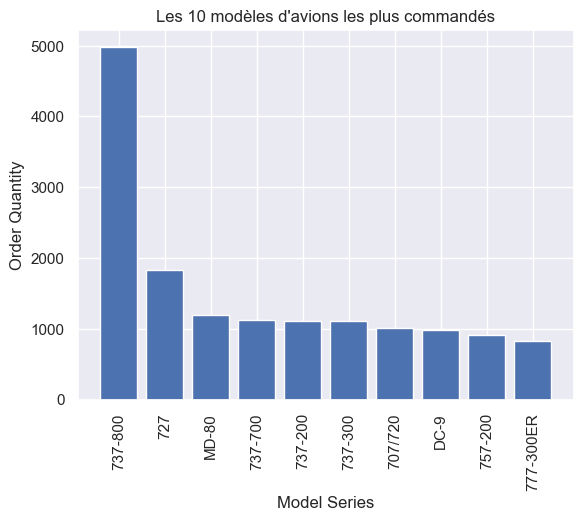

In [49]:
# Comme il y a 57 modèles d'avions, on s'intéresse aux avions les plus commandés
range = 10

X = "Model Series"
Y = "Order Total"
plt.bar(height=model_orders[Y][:range], x=model_orders[X][:range])
plt.xticks(rotation=90)
plt.xlabel("Model Series")
plt.ylabel("Order Quantity")
plt.title(f"Les {range} modèles d'avions les plus commandés")
plt.show()

In [50]:
# COMMENTAIRE
# On constate que le 737-800 se démarque fortement des autres modèles.

# Photo du 737-800
from IPython.display import Image
Image(url="boeing_737_800_generic_white_0000_turbosquid.jpg", width=600)

## <a id='toc4_3_'></a>[% de l'ensemble des clients ayant déjà commandé le top modèle (valeur)](#toc0_)

In [51]:
# On peut se demander quel pourcentage de l'ensemble des clients de Boeing ont déjà commandé une 737-800?

customer_737800 = dfOrders["Customer Name"][dfOrders["Model Series"] == "737-800"].nunique()*100/dfOrders["Customer Name"].nunique()
customer_737800 = round(customer_737800)
print(f"Ainsi, environ {customer_737800}% des clients de Boeing ont déjà commandé un 737-800")


Ainsi, environ 25% des clients de Boeing ont déjà commandé un 737-800


## <a id='toc4_4_'></a>[Type le plus commandé (histogramme)](#toc0_)

In [52]:
# Sous-échantillon utilisé: dfOrders
# Création sous-échantillon avec uniquement Type et Order Total

type_orders = dfOrders.groupby('Type')['Order Total'].sum().reset_index()

# Tri du nouveau sous-échantillon par modèle les plus commandés
type_orders = (type_orders.sort_values(by="Order Total", ascending=False))
display(type_orders.head())

,Type,Order Total
2,moyen-courrier,13410
1,long-courrier,7863
0,court-courrier,2733


In [53]:
# COMMENTAIRE
# Ainsi, on connaît le nombre total de commandes passées pour chaque type de vol.

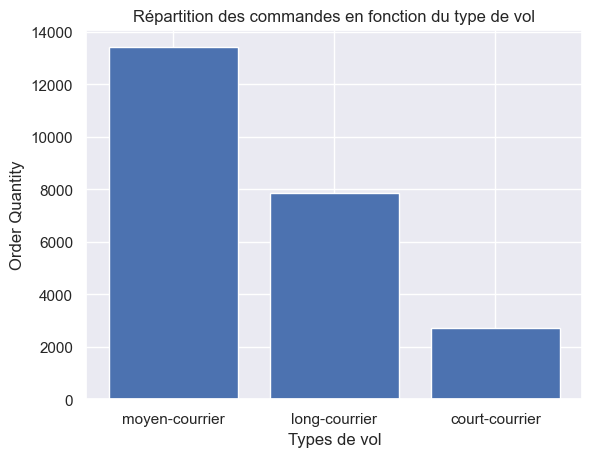

In [54]:
range = len(type_orders)

X = "Type"
Y = "Order Total"

plt.bar(height=type_orders[Y][:range], x=type_orders[X][:range])
plt.xticks(rotation=0)
plt.xlabel("Types de vol")
plt.ylabel("Order Quantity")
plt.title("Répartition des commandes en fonction du type de vol")
plt.show()

## <a id='toc4_5_'></a>[Utilisation la plus commune (histogramme)](#toc0_)

In [55]:
# Sous-échantillon utilisé: dfOrders
# Création sous-échantillon avec uniquement Utilisation et Order Total

utilisation_orders = dfOrders.groupby('Utilisation')['Order Total'].sum().reset_index()

# Tri du nouveau sous-échantillon par modèle les plus commandés
utilisation_orders = (utilisation_orders.sort_values(by="Order Total", ascending=False))
display(utilisation_orders.head())

,Utilisation,Order Total
1,avion commercial,21815
0,avion cargo,2039
2,avion privé et affaires,152


In [56]:
# COMMENTAIRE
# Ainsi, on connaît le nombre total de commandes passées pour chaque utilisation d'avion.

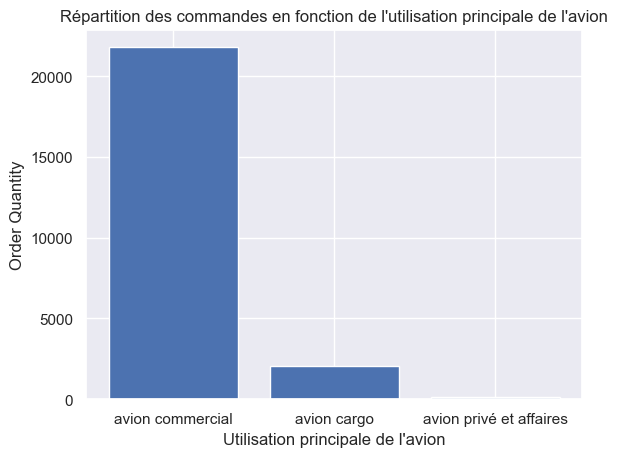

In [57]:
range = len(utilisation_orders)

X = "Utilisation"
Y = "Order Total"

plt.bar(height=utilisation_orders[Y][:range], x=utilisation_orders[X][:range])
plt.xticks(rotation=0)
plt.xlabel("Utilisation principale de l'avion")
plt.ylabel("Order Quantity")
plt.title("Répartition des commandes en fonction de l'utilisation principale de l'avion")
plt.show()

## <a id='toc4_6_'></a>[Total des commandes passées par Region (histogramme)](#toc0_)

In [58]:
# Sous-échantillon utilisé: dfOrders
# Création sous-échantillon avec uniquement Region et Order Total

region_orders = dfOrders.groupby('Region')['Order Total'].sum().reset_index()

# Tri du nouveau sous-échantillon par modèle les plus commandés
region_orders = (region_orders.sort_values(by="Order Total", ascending=False))
display(region_orders.head())

,Region,Order Total
7,North America,11241
5,Europe,5357
4,East Asia,2974
11,Southeast Asia,1207
6,Middle East,918


In [59]:
# COMMENTAIRE
# Ainsi, on connaît le nombre total de commandes passées pour chaque Region du monde.

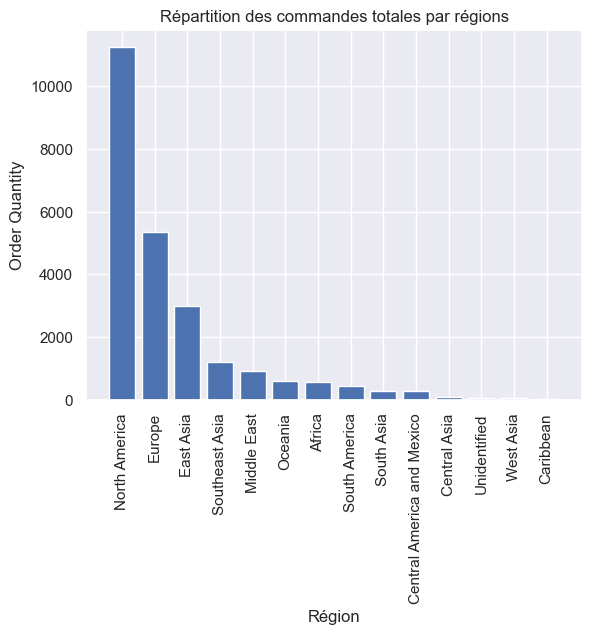

In [60]:
range = len(region_orders)

X = "Region"
Y = "Order Total"

plt.bar(height=region_orders[Y][:range], x=region_orders[X][:range])
plt.xticks(rotation=90)
plt.xlabel("Région")
plt.ylabel("Order Quantity")
plt.title("Répartition des commandes totales par régions")
plt.show()

## <a id='toc4_7_'></a>[Commandes passées par Region au fil des ans (boxplot)](#toc0_)

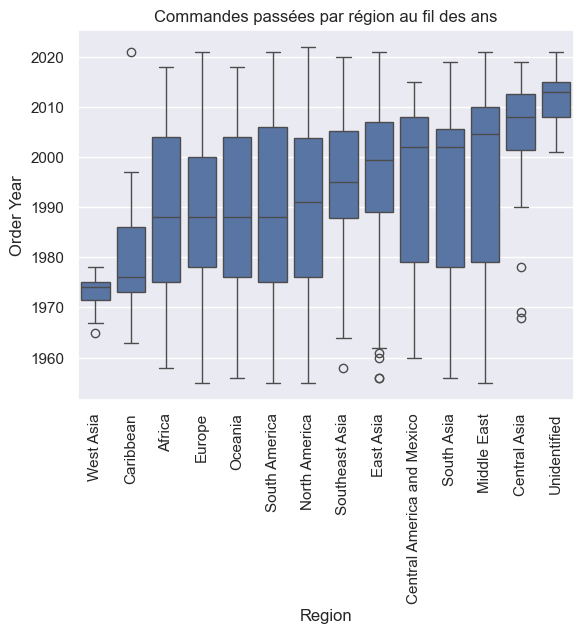

In [61]:

region_year = dfOrders[["Region", "Order Year"]]

# Order
my_order = region_year.groupby(["Region"])["Order Year"].median().sort_values(ascending=True)
                               
sns.boxplot(data = region_year, x = "Region", y = 'Order Year', order=my_order.index)
plt.xticks(rotation = 90)
plt.title("Commandes passées par région au fil des ans")
plt.show()

## <a id='toc4_8_'></a>[Evolution du nombre de commandes par année (histogramme)](#toc0_)

In [62]:
# Sous-échantillon utilisé: dfOrders
# Création sous-échantillon

df_filtered = dfOrders.groupby("Order Year")["Order Total"].sum().reset_index()
display(df_filtered)

,Order Year,Order Total
0,1955,143
1,1956,92
2,1957,35
3,1958,41
4,1959,35
...,...,...
63,2018,204
64,2019,64
65,2020,21
66,2021,55


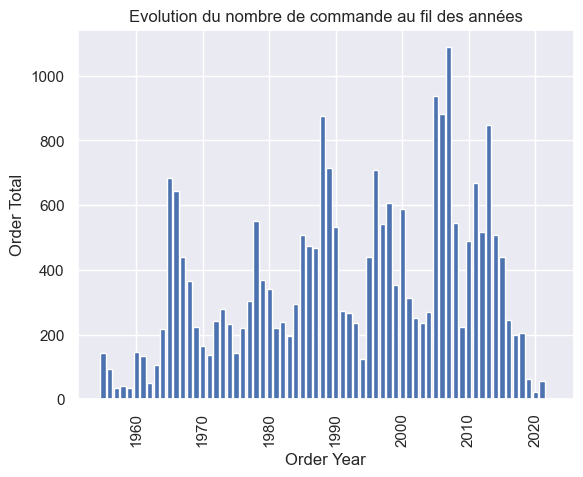

In [63]:
range = len(df_filtered)

X = "Order Year"
Y = "Order Total"

plt.bar(height=df_filtered[Y][:range], x=df_filtered[X][:range])
plt.xticks(rotation=90)
plt.xlabel(X)
plt.ylabel(Y)
plt.title("Evolution du nombre de commande au fil des années")
plt.show()

In [64]:
# COMMENTAIRE
# Il y a eu un pic pas loin de 2010, on peut regarder de plus près

In [65]:
# Création mask
condition = (df_filtered["Order Year"] >= 2004) & (df_filtered["Order Year"] < 2010)

# Création sous-échantillon filtré avec le mask
df_intervalle = df_filtered.loc[condition]
display(df_intervalle)


,Order Year,Order Total
49,2004,271
50,2005,936
51,2006,882
52,2007,1088
53,2008,544
54,2009,222


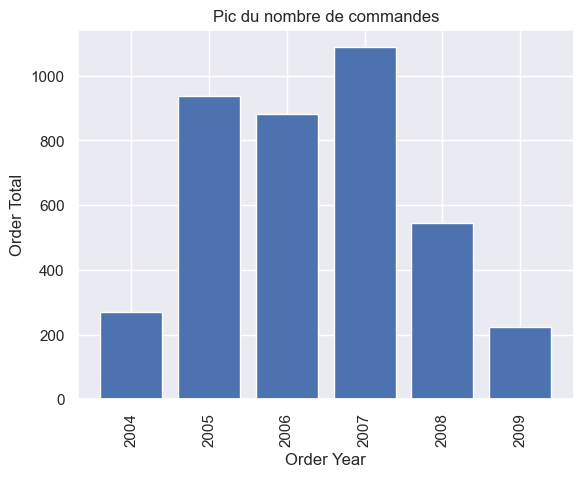

In [66]:
range = len(df_intervalle)

X = "Order Year"
Y = "Order Total"

plt.bar(height=df_intervalle[Y][:range], x=df_intervalle[X][:range])
plt.xticks(rotation=90)
plt.xlabel(X)
plt.ylabel(Y)
plt.title("Pic du nombre de commandes")
plt.show()

## <a id='toc4_9_'></a>[Clients ayant le plus commandé (histogramme)](#toc0_)

In [67]:
# Sous-échantillon utilisé: dfOrders
# Création sous-échantillon avec uniquement Customer Name et Order Total

customer_order = dfOrders.groupby("Customer Name")["Order Total"].sum().reset_index()

# Tri du nouveau sous-échantillon par nombre de commandes
customer_order = (customer_order.sort_values(by="Order Total", ascending=False))
display(customer_order.head())

,Customer Name,Order Total
478,United Airlines,1651
76,American Airlines,1299
168,Delta Air Lines,950
423,Southwest Airlines,841
240,International Lease Finance Co,799


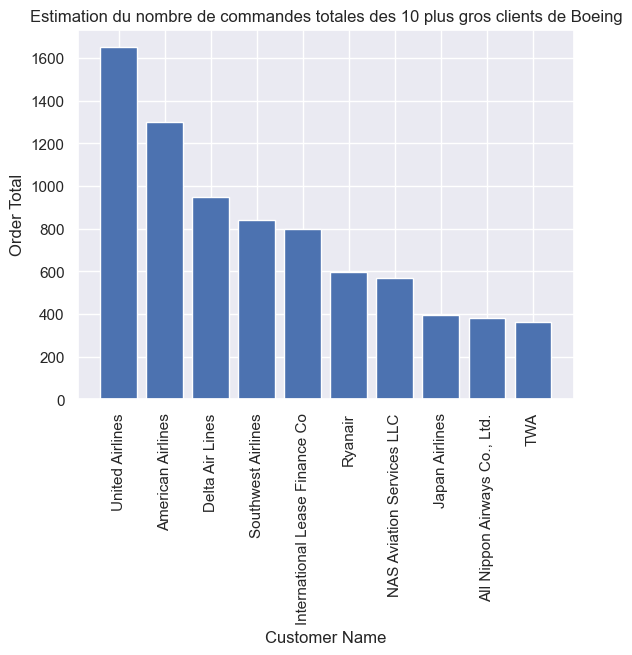

In [68]:
range = 10

X = "Customer Name"
Y = "Order Total"

plt.bar(height=customer_order[Y][:range], x=customer_order[X][:range])
plt.xticks(rotation=90)
plt.xlabel(X)
plt.ylabel(Y)
plt.title(f"Estimation du nombre de commandes totales des {range} plus gros clients de Boeing")
plt.show()

## <a id='toc4_10_'></a>[% de l'ensemble des clients ayant réalisé 5 commandes ou moins au total (valeur)](#toc0_)

In [69]:
customer_5max = customer_order["Customer Name"][customer_order["Order Total"] <= 5].nunique()*100/customer_order["Customer Name"].nunique()
customer_5max = round(customer_5max)
print(f"Ainsi, environ {customer_5max}% des clients de Boeing ont réalisé au maximum 5 commandes.")


Ainsi, environ 43% des clients de Boeing ont réalisé au maximum 5 commandes.


# <a id='toc5_'></a>[Conclusion](#toc0_)

Synthèse des commentaires

In [70]:
# COMMENTAIRE
# Ce dataframe nous a permis d'appréhender l'influence de Boeing dans le monde via le nombre de commandes réalisées depuis 1955. 
# Les principaux clients de l'entreprise sont des compagnies américaines et ce sont les avions commerciaux qui sont le plus commandés.

Limitation des données

In [71]:
# COMMENTAIRE
# Rappelons tout de même que les résultats représentent une estimation, sachant que le sous-échantillon dfOrders représente 89% du tableau brut (Commandes supposées non honorées non prises en compte).
# Par ailleurs, le tableau brut ainsi que le sous-échantillon dfOrders contient des lignes avec des valeurs non-identifiées (sauf concernant le nombre de commandes). Toutefois, cela représente 0,2% du tableau brut donc l'impact reste négligeable.